In [1]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib_inline.backend_inline import set_matplotlib_formats


set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm


import torch
import torch.nn as nn

import json

import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torch import optim

In [2]:
print(torch.__version__)

2.6.0+cu124


In [3]:
torch.manual_seed(42)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [5]:
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial3"

In [6]:
# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

In [7]:
x = torch.Tensor(2, 3, 4)
print(x)


tensor([[[-4.7576e-29,  4.3178e-41,  6.6075e-19,  0.0000e+00],
         [ 1.5081e-38,  0.0000e+00,  4.6932e+23,  4.3177e-41],
         [ 2.1897e+23,  4.3177e-41,  1.5080e-38,  0.0000e+00]],

        [[ 2.1897e+23,  4.3177e-41,  2.1896e+23,  4.3177e-41],
         [ 2.3916e+23,  4.3177e-41,  1.5081e-38,  0.0000e+00],
         [ 2.1895e+23,  4.3177e-41,  2.1173e+23,  4.3177e-41]]])


In [8]:
x = torch.tensor([[1,2], [2, 1]])
print(x)

tensor([[1, 2],
        [2, 1]])


In [9]:
x = torch.rand(3, 1, 4)

print(x)

tensor([[[0.8823, 0.9150, 0.3829, 0.9593]],

        [[0.3904, 0.6009, 0.2566, 0.7936]],

        [[0.9408, 0.1332, 0.9346, 0.5936]]])


In [10]:
shape = x.shape
print("Shape:", x.shape)

size = x.size()
print("Size:", size)

dim1, dim2, dim3 = x.size()
print("Size:", dim1, dim2, dim3)

Shape: torch.Size([3, 1, 4])
Size: torch.Size([3, 1, 4])
Size: 3 1 4


In [11]:
np_array = np.array([[1, 2], [3, 4]])
x = torch.from_numpy(np_array)
print("Numpy array:", np_array)
print("PyTorch tensor:", x)

Numpy array: [[1 2]
 [3 4]]
PyTorch tensor: tensor([[1, 2],
        [3, 4]])


In [12]:
tensor = torch.arange(4)
np_array = tensor.numpy()
print("PyTorch tensor:", tensor)
print("Numpy array:", np_array)

PyTorch tensor: tensor([0, 1, 2, 3])
Numpy array: [0 1 2 3]


In [13]:
x = torch.rand(2, 3)
y = torch.rand(2, 3)
z = x + y
print(z)

tensor([[1.1360, 1.1952, 1.0107],
        [0.8708, 1.1824, 1.4056]])


In [14]:
class ActivationFunction(nn.Module):

    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

In [15]:
##############################

class Sigmoid(ActivationFunction):

    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

##############################

class Tanh(ActivationFunction):

    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

##############################

In [16]:
##############################

class ReLU(ActivationFunction):

    def forward(self, x):
        return x * (x > 0).float()

##############################

class LeakyReLU(ActivationFunction):

    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

##############################

class ELU(ActivationFunction):

    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x)-1)

##############################

class Swish(ActivationFunction):

    def forward(self, x):
        return x * torch.sigmoid(x)

##############################

In [17]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish
}

In [18]:
def get_grads(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.

    Inputs:
        act_fn - An object of the class "ActivationFunction" with an implemented forward pass.
        x - 1D input tensor.
    Output:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = x.clone().requires_grad_() # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward() # Summing results in an equal gradient flow to each element in x
    return x.grad # Accessing the gradients of x by "x.grad"

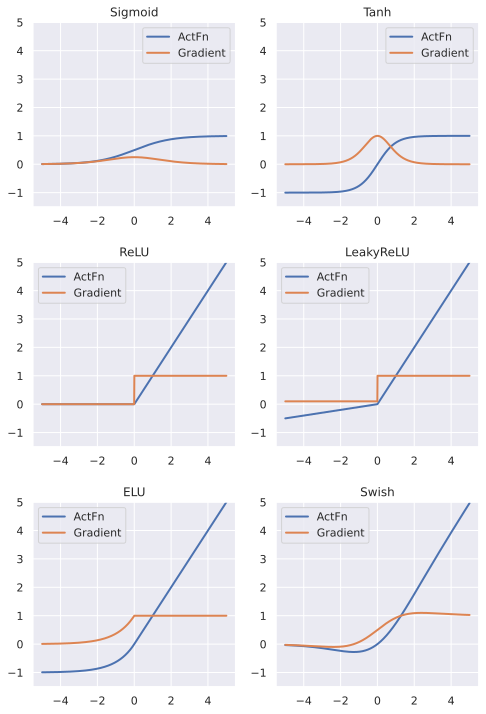

In [19]:
def vis_act_fn(act_fn, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ## Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000) # Range on which we want to visualize the activation functions
## Plotting
rows = math.ceil(len(act_fns)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

In [20]:
class BaseNetwork(nn.Module):

    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers) # nn.Sequential summarizes a list of modules into a single module, applying them in sequence

        # We store all hyperparameters in a dictionary for saving and loading of the model
        self.config = {"act_fn": act_fn.config, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes}

    def forward(self, x):
        x = x.view(x.size(0), -1) # Reshape images to a flat vector
        out = self.layers(x)
        return out


In [21]:
def _get_config_file(model_path, model_name):
  # Name of the file for storing hyperparameters details
  return os.path.join(model_path, model_name + "_config.json")


def _get_model_file(model_path, model_name):
  # Name of the file for storing network parameters
  return os.path.join(model_path, model_name + ".tar")


def load_model(model_path, model_name, net=None):
    """
    Loads a saved model from disk.

    Inputs:
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
        net - (Optional) If given, the state dict is loaded into this model. Otherwise, a new model is created.
    """
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net

def save_model(model, model_path, model_name):
    """
    Given a model, we save the state_dict and hyperparameters.

    Inputs:
        model - Network object to save parameters from
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

In [22]:
# Transformations applied on each image => first make them a tensor, then normalize them in the range -1 to 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root='./', train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root='./', train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 173kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.21MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 26.4MB/s]


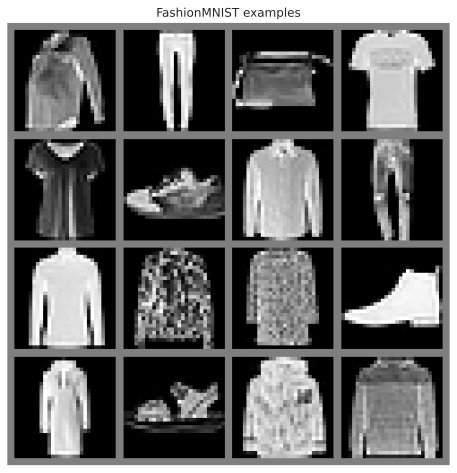

In [23]:
exmp_imgs = [train_set[i][0] for i in range(16)]
# Organize the images into a grid for nicer visualization
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [24]:
def visualize_gradients(net, color="C0"):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    net.eval()
    small_loader = DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    net.zero_grad()

    ## Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index%columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
        fig_index += 1
    fig.suptitle(f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

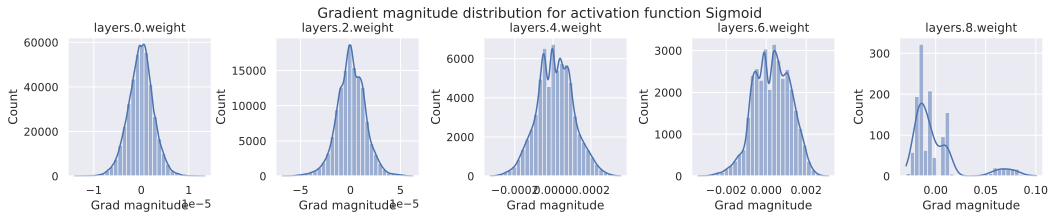

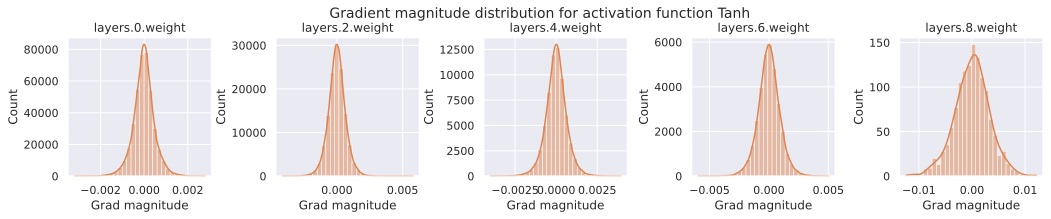

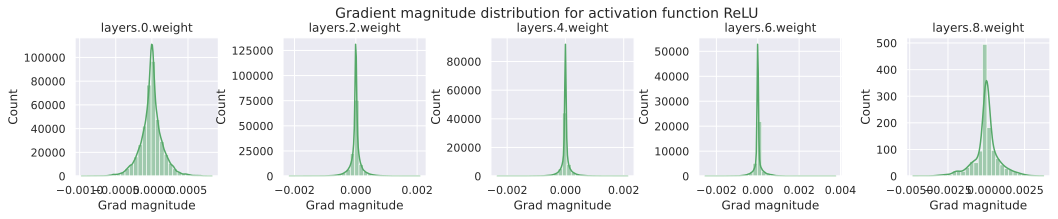

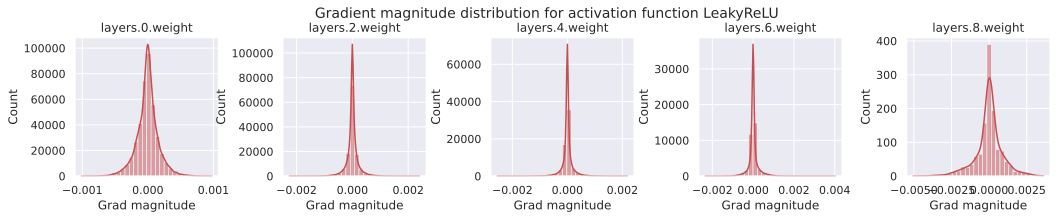

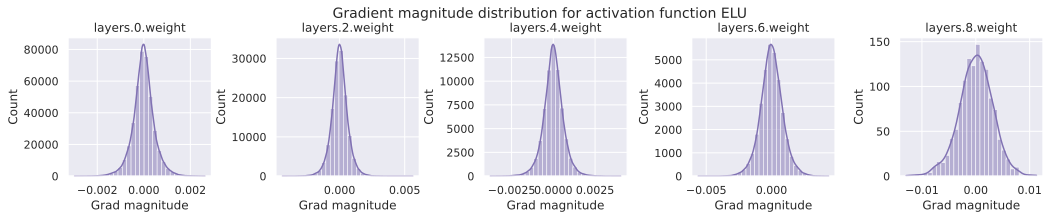

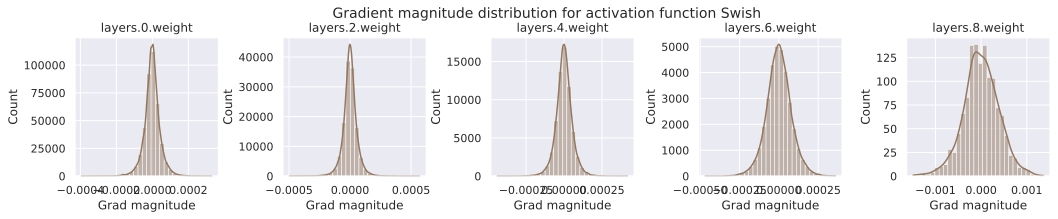

In [25]:
# Seaborn prints warnings if histogram has small values. We can ignore them for now
import warnings
warnings.filterwarnings('ignore')
## Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name):
    set_seed(42) # Setting the seed ensures that we have the same weight initialization for each activation function
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")

**Train Loop**

In [28]:
def train_loop(net, model_name, max_epochs=10, patience=7, batch_size=256, overwrite=False):
  """
  Train a model on the FashionMNIST dataset.

  Input:
    net - Object of class BaseNetwork
    model_name - Name of the model (str)
    max_epochs - Number of epochs we want to (maximally) train for
    patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
    batch_size - Size of batches used in training
    overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.

  Return:
    Test Acc
  """

  file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
  if file_exists and not overwrite:
    print('Model file already exists. Skipping training...')
  else:
    print('Model file does not exist. Training...')
    optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) # Default parameters, feel free to change
    loss_module = nn.CrossEntropyLoss()
    train_loader_local = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

    val_scores = []
    best_val_epoch = -1
    for epoch in range(max_epochs):
        ############
        # Training #
        ############
        net.train()
        true_preds, count = 0., 0
        for imgs, labels in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
            imgs, labels = imgs.to(device), labels.to(device) # To GPU
            optimizer.zero_grad() # Zero-grad can be placed anywhere before "loss.backward()"
            preds = net(imgs)
            loss = loss_module(preds, labels)
            loss.backward()
            optimizer.step()
            # Record statistics during training
            true_preds += (preds.argmax(dim=-1) == labels).sum()
            count += labels.shape[0]
        train_acc = true_preds / count

        ##############
        # Validation #
        ##############
        val_acc = test_model(net, val_loader)
        val_scores.append(val_acc)
        print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

        if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
            print("\t   (New best performance, saving model...)")
            save_model(net, CHECKPOINT_PATH, model_name)
            best_val_epoch = epoch
        elif best_val_epoch <= epoch - patience:
            print(f"Early stopping due to no improvement over the last {patience} epochs")
            break

    # Plot a curve of the validation accuracy
    plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.title(f"Validation performance of {model_name}")
    plt.show()
    plt.close()

  load_model(CHECKPOINT_PATH, model_name, net=net)
  test_acc = test_model(net, test_loader)
  print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=")+"\n")
  return test_acc



def test_model(net, data_loader):
    """
    Test a model on a specified dataset.

    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

Training BaseNetwork with sigmoid activation...
Model file already exists. Skipping training...
============= Test accuracy: 10.00% ==============

Training BaseNetwork with tanh activation...
Model file does not exist. Training...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 66.15%, Validation accuracy: 78.35%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 81.49%, Validation accuracy: 81.95%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 84.19%, Validation accuracy: 84.13%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 85.16%, Validation accuracy: 84.26%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 85.93%, Validation accuracy: 85.53%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 86.53%, Validation accuracy: 85.91%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 87.06%, Validation accuracy: 86.42%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 87.24%, Validation accuracy: 85.71%


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 87.82%, Validation accuracy: 86.01%


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 88.08%, Validation accuracy: 87.18%
	   (New best performance, saving model...)


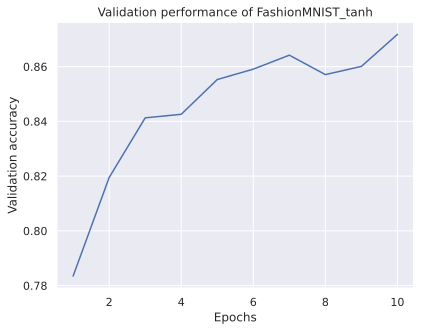

============= Test accuracy: 86.19% ==============

Training BaseNetwork with relu activation...
Model file does not exist. Training...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 50.45%, Validation accuracy: 73.04%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 79.09%, Validation accuracy: 80.93%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 83.50%, Validation accuracy: 83.95%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 84.82%, Validation accuracy: 84.96%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 86.03%, Validation accuracy: 85.29%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 87.02%, Validation accuracy: 86.44%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 87.68%, Validation accuracy: 86.89%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 88.01%, Validation accuracy: 87.28%
	   (New best performance, saving model...)


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 88.59%, Validation accuracy: 87.80%
	   (New best performance, saving model...)


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 89.22%, Validation accuracy: 87.82%
	   (New best performance, saving model...)


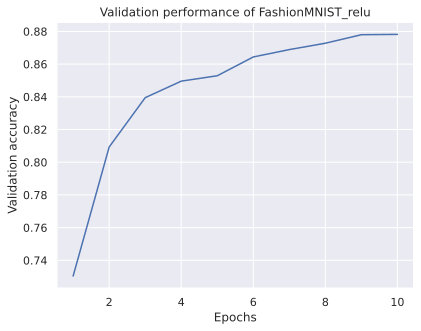

============= Test accuracy: 86.94% ==============

Training BaseNetwork with leakyrelu activation...
Model file does not exist. Training...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 51.91%, Validation accuracy: 74.04%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 79.42%, Validation accuracy: 81.13%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 83.42%, Validation accuracy: 83.79%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 84.79%, Validation accuracy: 84.82%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 85.81%, Validation accuracy: 85.16%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 86.78%, Validation accuracy: 86.34%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 87.26%, Validation accuracy: 86.67%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 87.75%, Validation accuracy: 87.09%
	   (New best performance, saving model...)


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 88.23%, Validation accuracy: 87.41%
	   (New best performance, saving model...)


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 88.92%, Validation accuracy: 87.80%
	   (New best performance, saving model...)


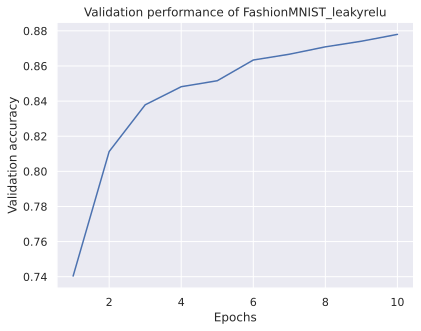

============= Test accuracy: 86.58% ==============

Training BaseNetwork with elu activation...
Model file does not exist. Training...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 66.23%, Validation accuracy: 78.89%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 81.70%, Validation accuracy: 82.24%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 84.00%, Validation accuracy: 83.99%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 85.01%, Validation accuracy: 84.35%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 85.57%, Validation accuracy: 85.31%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 86.35%, Validation accuracy: 85.81%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 86.84%, Validation accuracy: 85.68%


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 86.95%, Validation accuracy: 85.70%


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 87.34%, Validation accuracy: 85.62%


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 87.80%, Validation accuracy: 86.67%
	   (New best performance, saving model...)


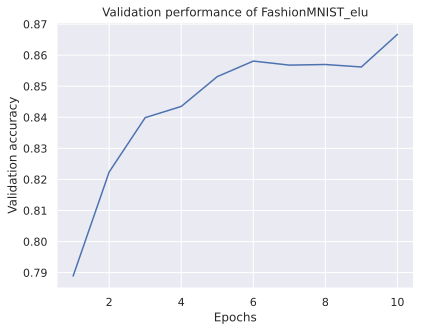

============= Test accuracy: 85.75% ==============

Training BaseNetwork with swish activation...
Model file does not exist. Training...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 25.23%, Validation accuracy: 31.80%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 64.96%, Validation accuracy: 73.38%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 79.51%, Validation accuracy: 81.53%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 82.50%, Validation accuracy: 83.33%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 83.70%, Validation accuracy: 84.06%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 84.92%, Validation accuracy: 84.40%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 85.60%, Validation accuracy: 85.38%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 85.90%, Validation accuracy: 85.09%


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 86.55%, Validation accuracy: 85.32%


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 86.89%, Validation accuracy: 86.17%
	   (New best performance, saving model...)


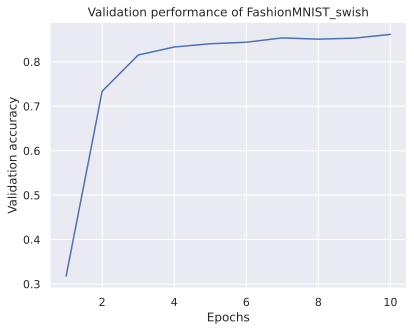

============= Test accuracy: 85.44% ==============



In [29]:
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_loop(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)

In [32]:
def visualize_activations(net, color="C0"):
    activations = {}

    net.eval()
    small_loader = DataLoader(train_set, batch_size=1024)
    imgs, labels = next(iter(small_loader))
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        # We need to manually loop through the layers to save all activations
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy()

    ## Plotting
    columns = 4
    rows = math.ceil(len(activations)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*2.7, rows*2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index//columns][fig_index%columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {key} - {net.layers[key].__class__.__name__}")
        fig_index += 1
    fig.suptitle(f"Activation distribution for activation function {net.config['act_fn']['name']}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close()

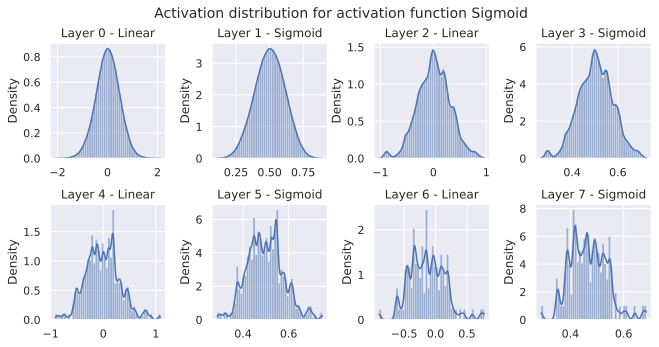

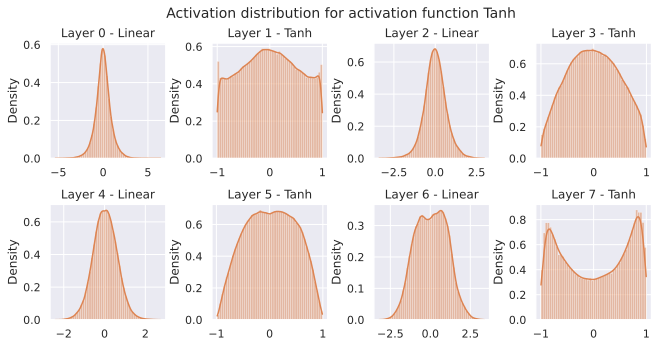

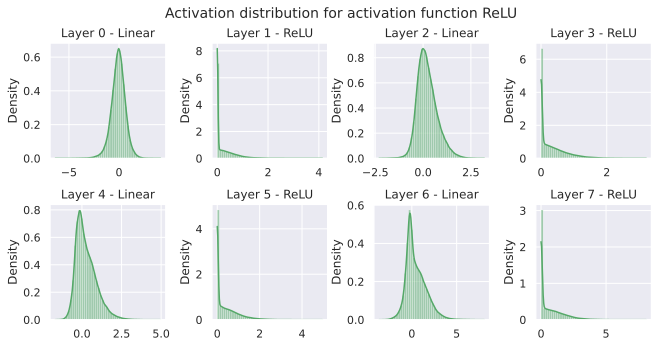

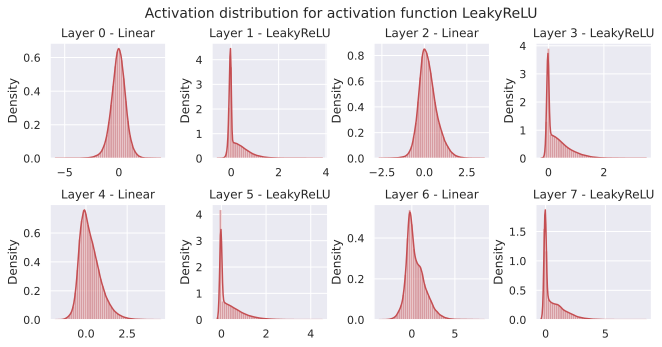

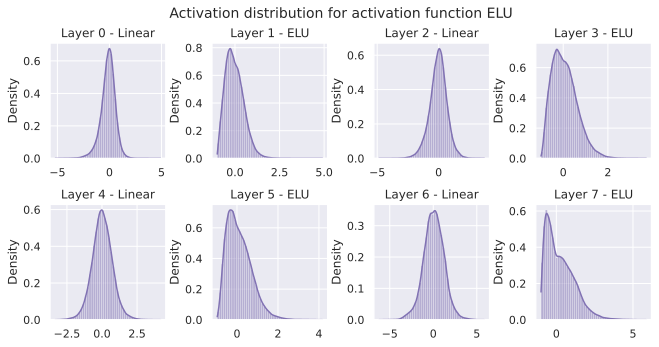

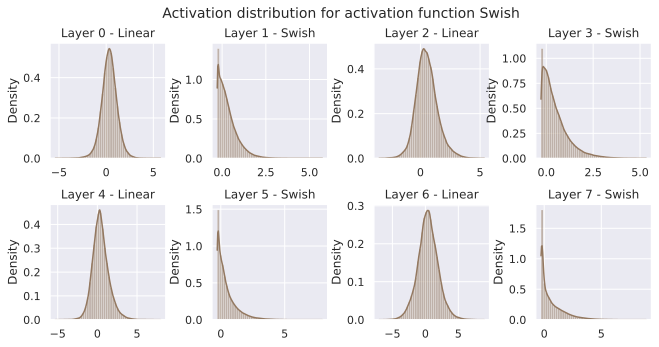

In [33]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name=f"FashionMNIST_{act_fn_name}").to(device)
    visualize_activations(net_actfn, color=f"C{i}")

In [34]:
def measure_number_dead_neurons(net):

    # For each neuron, we create a boolean variable initially set to 1. If it has an activation unequals 0 at any time,
    # we set this variable to 0. After running through the whole training set, only dead neurons will have a 1.
    neurons_dead = [
        torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool) for layer in net.layers[:-1] if isinstance(layer, nn.Linear)
    ] # Same shapes as hidden size in BaseNetwork

    net.eval()
    with torch.no_grad():
        for imgs, labels in tqdm(train_loader, leave=False): # Run through whole training set
            layer_index = 0
            imgs = imgs.to(device)
            imgs = imgs.view(imgs.size(0), -1)
            for layer in net.layers[:-1]:
                imgs = layer(imgs)
                if isinstance(layer, ActivationFunction):
                    # Are all activations == 0 in the batch, and we did not record the opposite in the last batches?
                    neurons_dead[layer_index] = torch.logical_and(neurons_dead[layer_index], (imgs == 0).all(dim=0))
                    layer_index += 1
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("Number of dead neurons:", number_neurons_dead)
    print("In percentage:", ", ".join([f"{(100.0 * num_dead / tens.shape[0]):4.2f}%" for tens, num_dead in zip(neurons_dead, number_neurons_dead)]))

In [35]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU()).to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 3, 10]
In percentage: 0.00%, 0.00%, 1.17%, 7.81%


In [36]:
net_relu = load_model(model_path=CHECKPOINT_PATH, model_name="FashionMNIST_relu").to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 3, 8]
In percentage: 0.00%, 0.00%, 1.17%, 6.25%


In [38]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU(), hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128]).to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 7, 27, 89, 60, 58, 61, 72, 56]
In percentage: 0.00%, 0.00%, 2.73%, 10.55%, 34.77%, 46.88%, 45.31%, 47.66%, 56.25%, 43.75%
